#### Well-logs data from Utah Forge Project    https://gdr.openei.org/submissions/1111



In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

In [151]:
#read csv saved in DataInspection_UtahForge_58 notebook
all_logs = (pd.read_csv('./data/all_logs.csv')).set_index('DEPT')
#all_logs.info()

In [152]:
#read discrete data - conversion to ft - depth equal to lower depth interval 
tops = pd.read_csv('./data/58-32_tops.csv')

#Thermal Conductivity 
TC_coredata = pd.read_csv ('./data/58-32_thermal_conductivity_data.csv') 
TC_coredata['Depth'] = (3.28084*TC_coredata['Lower Depth Interval (m)'])
TC_coredata['Matrix_TC']=TC_coredata['matrix thermal conductivity (W/m deg C)']
TC_coredata.set_index('Depth', inplace=True)

#XRD lab data
XRD_coredata = pd.read_csv ('./data/58-32_xray_diffraction_data.csv') 
XRD_coredata = XRD_coredata.replace('tr',0)
XRD_coredata['Depth'] = (3.28084*XRD_coredata['Lower Depth Range (m)'])
XRD_coredata.set_index('Depth', inplace=True)

#XRD_coredata.tail()

In [153]:
#Interpolation TC measurement to wireline logs scale
core = pd.concat([TC_coredata, XRD_coredata], axis=1, sort=False)
#core.head(5)
all_logs = pd.merge(all_logs, core, how = 'outer', left_index = True, right_index = True)
all_logs['Matrix_TC_int'] = all_logs['Matrix_TC'].interpolate(method = 'linear').dropna()
#all_logs.head(20)

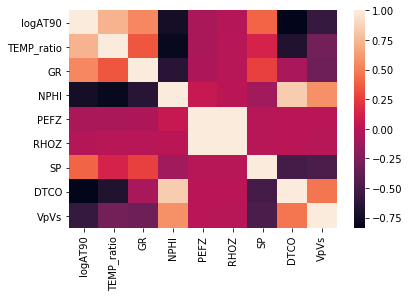

In [154]:
#calcualtion of TEMP_ratio
all_logs['TEMP_ratio']=all_logs['CTEM']/all_logs['Matrix_TC_int']
all_logs['logAT90']=np.log10(dfmerged['AT90'])
all_logs_corr = all_logs[['logAT90', 'TEMP_ratio', 'GR', 'NPHI', 'PEFZ', 'RHOZ', 'SP', 'DTCO', 'VpVs']]
corr_matrix = all_logs_corr.corr()
sns.heatmap(corr_matrix);

In [155]:
all_logs['TEMP_ratio'].describe()

count    14948.000000
mean        76.546578
std         20.396199
min         44.175761
25%         58.170301
50%         81.473548
75%         93.685395
max        111.882579
Name: TEMP_ratio, dtype: float64

In [156]:
#filter logs for view and clustering 
all_logs_class = all_logs[['GR', 'SP', 'DCAL', 
                           'RHOZ', 'NPHI', 'PEFZ',
                           'logAT90', 'AT10', 'AT30', 'AT90',
                           'DTSM', 'DTCO', 'VpVs', 
                           'CTEM','TEMP_ratio']].dropna()

all_logs_class_x =all_logs_class[['TEMP_ratio', 'GR','RHOZ', 'SP', 'VpVs']]
x = preprocessing.scale(all_logs_class_x)
#all_logs_class_x.info()

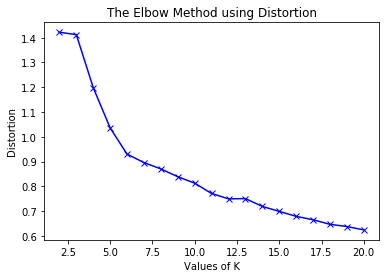

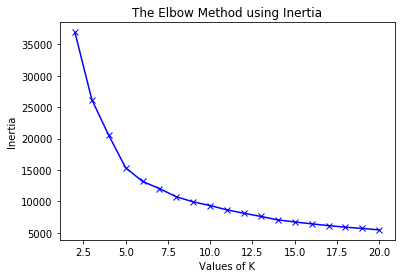

In [119]:
distortions = [] 
inertias = [] 
K = range(2,21) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, max_iter = 50, random_state = 42).fit(x) 
    kmeanModel.fit(x)     
      
    distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / x.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [157]:
KMeans_classifier = KMeans(n_clusters = 6, max_iter = 50, random_state = 42)
KMeans_classifier.fit(x)
y_pred_KMeans = KMeans_classifier.predict(x)
len(y_pred_KMeans)

10741

In [158]:
# ADD KMEANS THERMOFACIES TO all _logs_class df
all_logs_class['THERMOFACIES'] = y_pred_KMeans
#all_logs_class['THERMOFACIES'].describe()

In [159]:
#basic plot to inspect data MODIFY TO SHOW THERMOFACIES
def make_layout_thermofacies (log_df, XRD, TC):
    
    import numpy as np
    import pandas as pd
    import matplotlib
    import matplotlib.pyplot as plt
  
    clusterml=np.repeat(np.expand_dims(log_df['THERMOFACIES'].values,1), 100, 1)
    ztop=log_df.index.min(); zbot=log_df.index.max()
    
    fig, axs = plt.subplots(nrows=1, ncols=7, sharey=True, squeeze=True, figsize=(15, 15), gridspec_kw={'wspace': 0.25})
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
    axs[0].set_ylabel('Depth (ft)')
    axs[0].invert_yaxis()
    axs[0].get_xaxis().set_visible(False)
    
    # First track GR/SP/CALI logs to display
    ax1 = axs[0].twiny()  
    ax1.plot(log_df.GR, log_df.index, '-', color='#2ea869', linewidth=0.5)
    ax1.set_xlim(0,450) 
    ax1.set_xlabel('GR (API)', color='#2ea869')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15)) 
    
    ax2 = axs[0].twiny() 
    ax2.plot(log_df.SP, log_df.index, '-', color='#0a0a0a', linewidth=0.7)
    ax2.set_xlim(-200,200) 
    ax2.set_xlabel('SP(mV)', color='#0a0a0a')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))    
      
    ax3 = axs[0].twiny() 
    ax3.plot(log_df.DCAL, log_df.index, '--', color='#9da4a1', linewidth=0.5)
    ax3.set_xlim(-5,15) 
    ax3.set_xlabel('DCAL (in)', color='#9da4a1')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[0].get_xaxis().set_visible(False)
    
    # Second track RHOB/NPHI/PEF logs to display
    ax1 = axs[1].twiny()  
    ax1.plot(log_df.RHOZ, log_df.index, '-', color='#ea0606', linewidth=0.5)
    ax1.set_xlim(1.5,3.0) 
    ax1.set_xlabel('RHOB (g/cm3)', color='#ea0606')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[1].twiny()  
    ax2.plot(log_df.NPHI, log_df.index, '-', color='#1577e0', linewidth=0.5)
    ax2.set_xlim(1,0) 
    ax2.set_xlabel('NPHI (v/v)', color='#1577e0')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[1].twiny()  
    ax3.plot(log_df.PEFZ, log_df.index, '-', color='#1acb20', linewidth=0.5)
    ax3.set_xlim(0,15) 
    ax3.set_xlabel('PEFZ (b/e)', color='#1acb20')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[1].get_xaxis().set_visible(False)
    
    # Third track Resistivities
    ax1 = axs[2].twiny()  
    ax1.plot(log_df.AT10, log_df.index, '-', color='#d6dbd7', linewidth=0.5)
    ax1.set_xlim(0.2,20000)  
    ax1.set_xlabel('AT10 (ohm.m)', color='#d6dbd7')
    ax1.set_xscale('log')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))
    
    ax2 = axs[2].twiny()  
    ax2.plot(log_df.AT30, log_df.index, '-', color='#0a0a0a', linewidth=0.5)
    ax2.set_xlim(0.2,20000)  
    ax2.set_xlabel('AT30 (ohm.m)', color='#0a0a0a')
    ax2.set_xscale('log')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[2].twiny()  
    ax3.plot(log_df.AT90, log_df.index, '-', color='#ea0606', linewidth=0.5)
    ax3.set_xlim(0.2,20000)  
    ax3.set_xlabel('AT90 (ohm.m)', color='#ea0606')
    ax3.set_xscale('log')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[2].get_xaxis().set_visible(False)

   # Forth track Sonic
    ax1 = axs[3].twiny()  
    ax1.plot(log_df.DTSM, log_df.index, '-', color='#9da4a1', linewidth=0.5)
    ax1.set_xlim(200,40) 
    ax1.set_xlabel('DTS (us/ft)', color='#9da4a1')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))
    
    ax2 = axs[3].twiny()  
    ax2.plot(log_df.DTCO, log_df.index, '-', color='#0a0a0a', linewidth=0.5)
    ax2.set_xlim(200,40) 
    ax2.set_xlabel('DTC (us/ft)', color='#0a0a0a')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[3].twiny()  
    ax3.plot(log_df.VpVs, log_df.index, '-', color='#e1093f', linewidth=0.5)
    ax3.set_xlim(1,3) 
    ax3.set_xlabel('VpVs (unitless)', color='#e1093f')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[3].get_xaxis().set_visible(False)


  # Fifth track XRD to display
    ax1 = axs[4].twiny()  
    ax1.plot(XRD.Quartz, XRD.index, 'o', color='#eac406')
    ax1.set_xlim(0,100) 
    ax1.set_xlabel('Quartz %', color='#eac406')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[4].twiny()  
    ax2.plot(XRD['K-feldspar'], XRD.index, 'o', color='#05a9f0')
    ax2.set_xlim(0,100) 
    ax2.set_xlabel('K-feldspar %', color='#05a9f0')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[4].twiny()  
    ax3.plot(XRD['Illite'], XRD.index, 'o', color='#94898c')
    ax3.set_xlim(0,100) 
    ax3.set_xlabel('Illite %', color='#94898c')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[4].get_xaxis().set_visible(False)


    # Sixth track Temp/TC to display
    ax1 = axs[5].twiny()  
    ax1.plot(TC.Matrix_TC, TC.index, 'o', color='#6e787c')
    ax1.set_xlim(0,5) 
    ax1.set_xlabel('Matrix TC Measured W/mC', color='#6e787c')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[5].twiny()  
    ax2.plot(log_df.CTEM, log_df.index, '-', color='#ed8712')
    ax2.set_xlim(0,300) 
    ax2.set_xlabel('Temp degF', color='#ed8712')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[5].twiny()
    ax3.plot(log_df.TEMP_ratio, log_df.index, '-', color='#eb6105')
    #ax3.set_xlim(log_df.TEMP_ratio.min,log_df.TEMP_ratio.max)
    ax3.set_xlabel('Temp ratio', color='#eb6105')
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[5].get_xaxis().set_visible(False)
    
    # Seventh track ML Facies  
    ax1=axs[6]
    ax1.set_xlabel('Facies ML')
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    im=ax1.imshow(clusterml, cmap='Set1', aspect='auto', extent=[0,1,zbot, ztop], vmin=0,vmax=11)
         
    fig.suptitle('Thermofacies for UTAH FORGE 58-32',weight='bold', fontsize=20, y=0.9);
    plt.show()


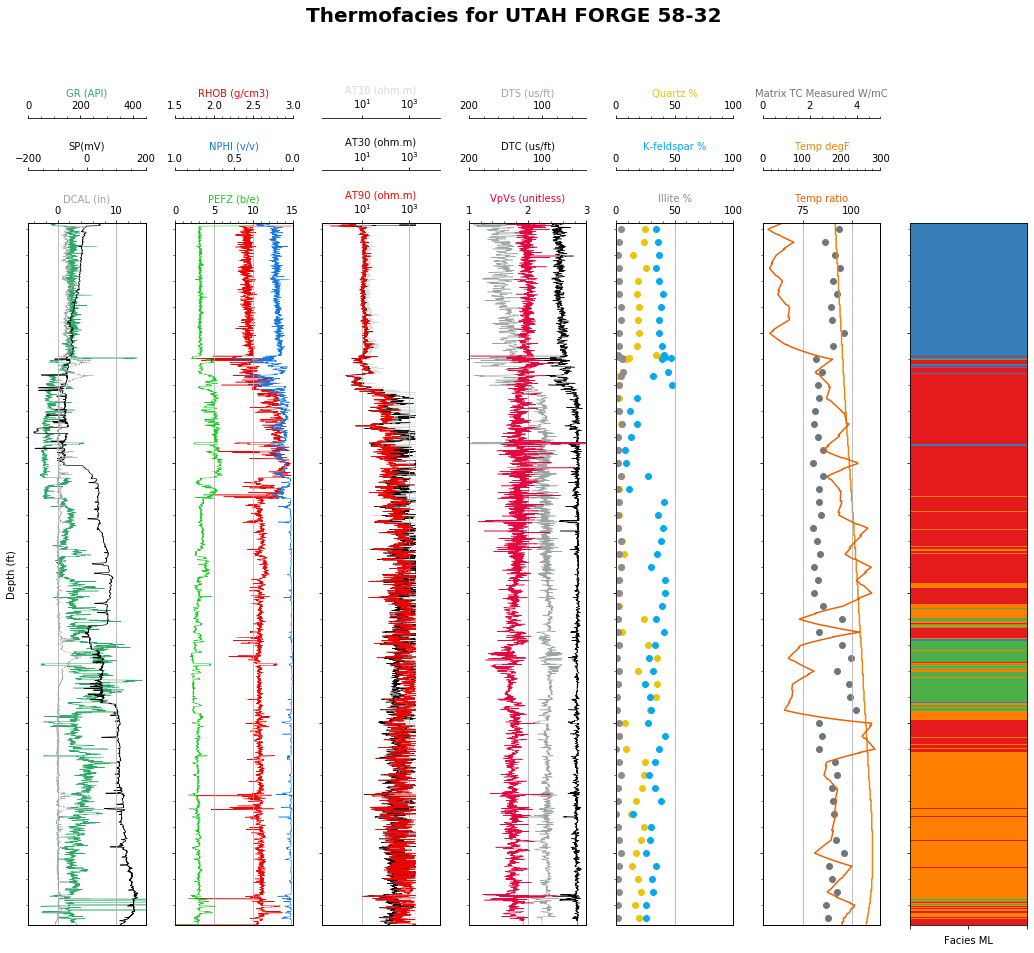

In [160]:
make_layout_thermofacies (all_logs_class, XRD_coredata, TC_coredata)

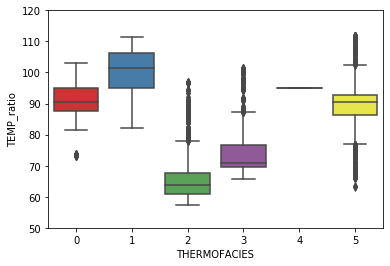

In [161]:
#boxplots - WRONG colors sequence - to fix
sns.boxplot(x='THERMOFACIES', y='TEMP_ratio', data=all_logs_class, palette = 'Set1')
plt.ylim(50,120);